In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os
import seaborn as sns
import random 
import dask
import babet as bb
from moarpalettes import get_palette
from cartopy import crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as patches
from cmcrameri import cm
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import FuncFormatter, ScalarFormatter
from moarpalettes import get_palette

sns.set_theme(style="white")
sns.set_style("white")

random.seed(10)
# inidates = ['2023-10-11', '2023-10-15', '2023-10-17']
inidates = ['2023-10-15', '2023-10-17']
experiments = ['pi', 'curr', 'incr']

dask.config.set(**{'array.slicing.split_large_chunks': True})

In [2]:
color_palette = get_palette.Petroff6().to_sn_palette()
color_palette

[(0.3411764705882353, 0.5647058823529412, 0.9882352941176471),
 (0.9725490196078431, 0.611764705882353, 0.12549019607843137),
 (0.8941176470588236, 0.1450980392156863, 0.21176470588235294),
 (0.5882352941176471, 0.2901960784313726, 0.5450980392156862),
 (0.611764705882353, 0.611764705882353, 0.6313725490196078),
 (0.47843137254901963, 0.12941176470588237, 0.8666666666666667)]

In [3]:
# Plot settings

# UK
lat_max = 62
lat_min = 47
lon_min = -12
lon_max = 5

euroatlantic = [lon_min-13, lon_max, lat_min-5, lat_max+6]
uk = [-11, 10, 45, 65] # longitude min, longitude max, latitude min, latitude max
northsea = [-17, 20, 40, 70]

# Load data

In [4]:
# ERA5 of the event
file_dir = '/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/ERA5/EU025/sfc/2023.nc'
era5 = xr.open_dataset(file_dir)
era5_babet_msl = era5.msl.sel(time=slice('2023-10-19 00', '2023-10-22 00')).mean(dim='time')/100
era5_babet_tp = era5.tp.sel(time=slice('2023-10-19 00', '2023-10-22 00')).sum(dim='time')*1000

In [5]:
# ERA5 analogues
era5_analogues = bb.data.Data.get_era5_analogues()

Importing data from pre-existing file


In [6]:
# RACMO inidvidual analogues
racmo_msl, racmo_tp = bb.data.Data.get_racmo_indiv_analogues()

Importing data from pre-existing file


In [7]:
# PGW ens members
pgw_ens = bb.data.Data.get_pgw_ensemble()

Importing data from pre-existing file


In [8]:
# FBA IFS
ifs = bb.data.Data.get_fba_ifs()

In [9]:
#FBA ACCESS MICAS
micas = bb.data.Data.get_fba_micas()

Importing data from pre-existing file


# Data processing

Note that the order that the map extents have to be given to the ```.sel``` function differ from dataset to dataset. You will notice immediately if something is off becausde you will end up with only nans if you do it wrong.

In [10]:
# ERA5 analogues
era5_analogues['tp'] = era5_analogues['tp'].sel(lat=slice(uk[3], uk[2]), lon=slice(uk[0], uk[1]))
era5_analogues['msl'] = era5_analogues['msl'].sel(lat=slice(uk[3], uk[2]), lon=slice(uk[0], uk[1]))/100
era5_analogues['t2m'] = era5_analogues['t2m'].sel(lat=slice(uk[3], uk[2]), lon=slice(uk[0], uk[1]))

In [11]:
# RACMO analogues
racmo_tp['tp'] = racmo_tp['tp'].sel(lat=slice(uk[2], uk[3]), lon=slice(uk[0], uk[1]))*3*24*3600
racmo_msl['msl'] = racmo_msl['msl'].sel(lat=slice(uk[3], uk[2]), lon=slice(uk[0], uk[1]))/100

In [12]:
# PGW
# pgw['tp'] = (((pgw.tp.sel(time=slice('2023-10-19 00', '2023-10-22 00'))).sum(dim='time'))).sel(lat=slice(uk[2], uk[3]), lon=slice(uk[0], uk[1]))/24*3
# pgw['msl'] = (pgw.msl.sel(time=slice('2023-10-19 00', '2023-10-22 00'), lat=slice(uk[2], uk[3]), lon=slice(uk[0], uk[1])).mean('time').squeeze())/100
# pgw['t2m'] = (pgw.t2m.sel(time=slice('2023-10-19 00', '2023-10-22 00'), lat=slice(uk[2], uk[3]), lon=slice(uk[0], uk[1])).mean('time').squeeze())

In [13]:
pgw_ens['tp'] = (((pgw_ens.tp.sel(time=slice('2023-10-19 00', '2023-10-22 00'))).sum(dim='time'))).sel(lat=slice(uk[2], uk[3]), lon=slice(uk[0], uk[1]))/24*3
pgw_ens['msl'] = (pgw_ens.msl.sel(time=slice('2023-10-19 00', '2023-10-22 00'), lat=slice(uk[2], uk[3]), lon=slice(uk[0], uk[1])).mean('time').squeeze())/100
pgw_ens['t2m'] = (pgw_ens.t2m.sel(time=slice('2023-10-19 00', '2023-10-22 00'), lat=slice(uk[2], uk[3]), lon=slice(uk[0], uk[1])).mean('time').squeeze())

In [14]:
# FBA IFS
ifs['tp'] = ((ifs.tp.sel(time='2023-10-22 00') - ifs.tp.sel(time='2023-10-19 00'))*1000).sel(latitude=slice(uk[3], uk[2]), longitude=slice(uk[0], uk[1]))
ifs['msl'] = ifs.msl.sel(time=slice('2023-10-19 00', '2023-10-22 00'), latitude=slice(uk[3], uk[2]), longitude=slice(uk[0], uk[1])).mean(dim='time')/100
ifs['t2m'] = ifs.t2m.sel(time=slice('2023-10-19 00', '2023-10-22 00'), latitude=slice(uk[3], uk[2]), longitude=slice(uk[0], uk[1])).mean(dim='time')

In [15]:
# ACCESS MICAS
micas['tp'] = micas.tp.sel(time=slice('2023-10-19 12', '2023-10-21 12'), lat=slice(uk[2], uk[3]), lon=slice(uk[0], uk[1])).sum(dim='time')*24*3600
micas['msl'] = micas.msl.sel(time=slice('2023-10-19 12', '2023-10-21 12'), lat=slice(uk[2], uk[3]), lon=slice(uk[0], uk[1])).mean(dim='time')/100
micas['tas'] = micas.tas.sel(time=slice('2023-10-19 12', '2023-10-21 12'), lat=slice(uk[2], uk[3]), lon=slice(uk[0], uk[1])).mean(dim='time')

In [16]:
def is_significant(da):
    """
    Function to determine if a variable is significantly different from zero
    """
    return ((da.sel(percentile=2.5) <= 0) & (0 <= da.sel(percentile=97.5))) | ((da.sel(percentile=97.5) <= 0) & (0 <= da.sel(percentile=2.5)))

In [17]:
base_dir = '/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/postproc/significance/'

# ERA5 analogues
tmp = xr.open_dataset(base_dir+'era5_analogues_tp_sign_map.nc')
era5_analogues_sign = tmp.groupby('climate').apply(is_significant)

# RACMO analogues
tmp = xr.open_dataset(base_dir+'racmo_tp_sign_map.nc')
racmo_sign = tmp.groupby('climate').apply(is_significant)

# PGW
pgw_sign = xr.open_dataset(base_dir+'pgw_tp_sign_map.nc')
pgw_sign = pgw_sign.groupby('climate').apply(is_significant)

# FBA IFS
tmp = xr.open_dataset(base_dir+'ifs_tp_sign_map.nc')
ifs_sign = tmp.groupby('climate').apply(is_significant)

# ACCESS MICAS
tmp = xr.open_dataset(base_dir+'micas_tp_sign_map.nc')
micas_sign = tmp.groupby('climate').apply(is_significant)

# Map plot

In [18]:
uk = [-10.5, 9.5, 45.5, 61.3] # longitude min, longitude max, latitude min, latitude max

/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1714: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1714: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1714: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1714: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = matplotlib.axes.Axes.contourf(self, *args

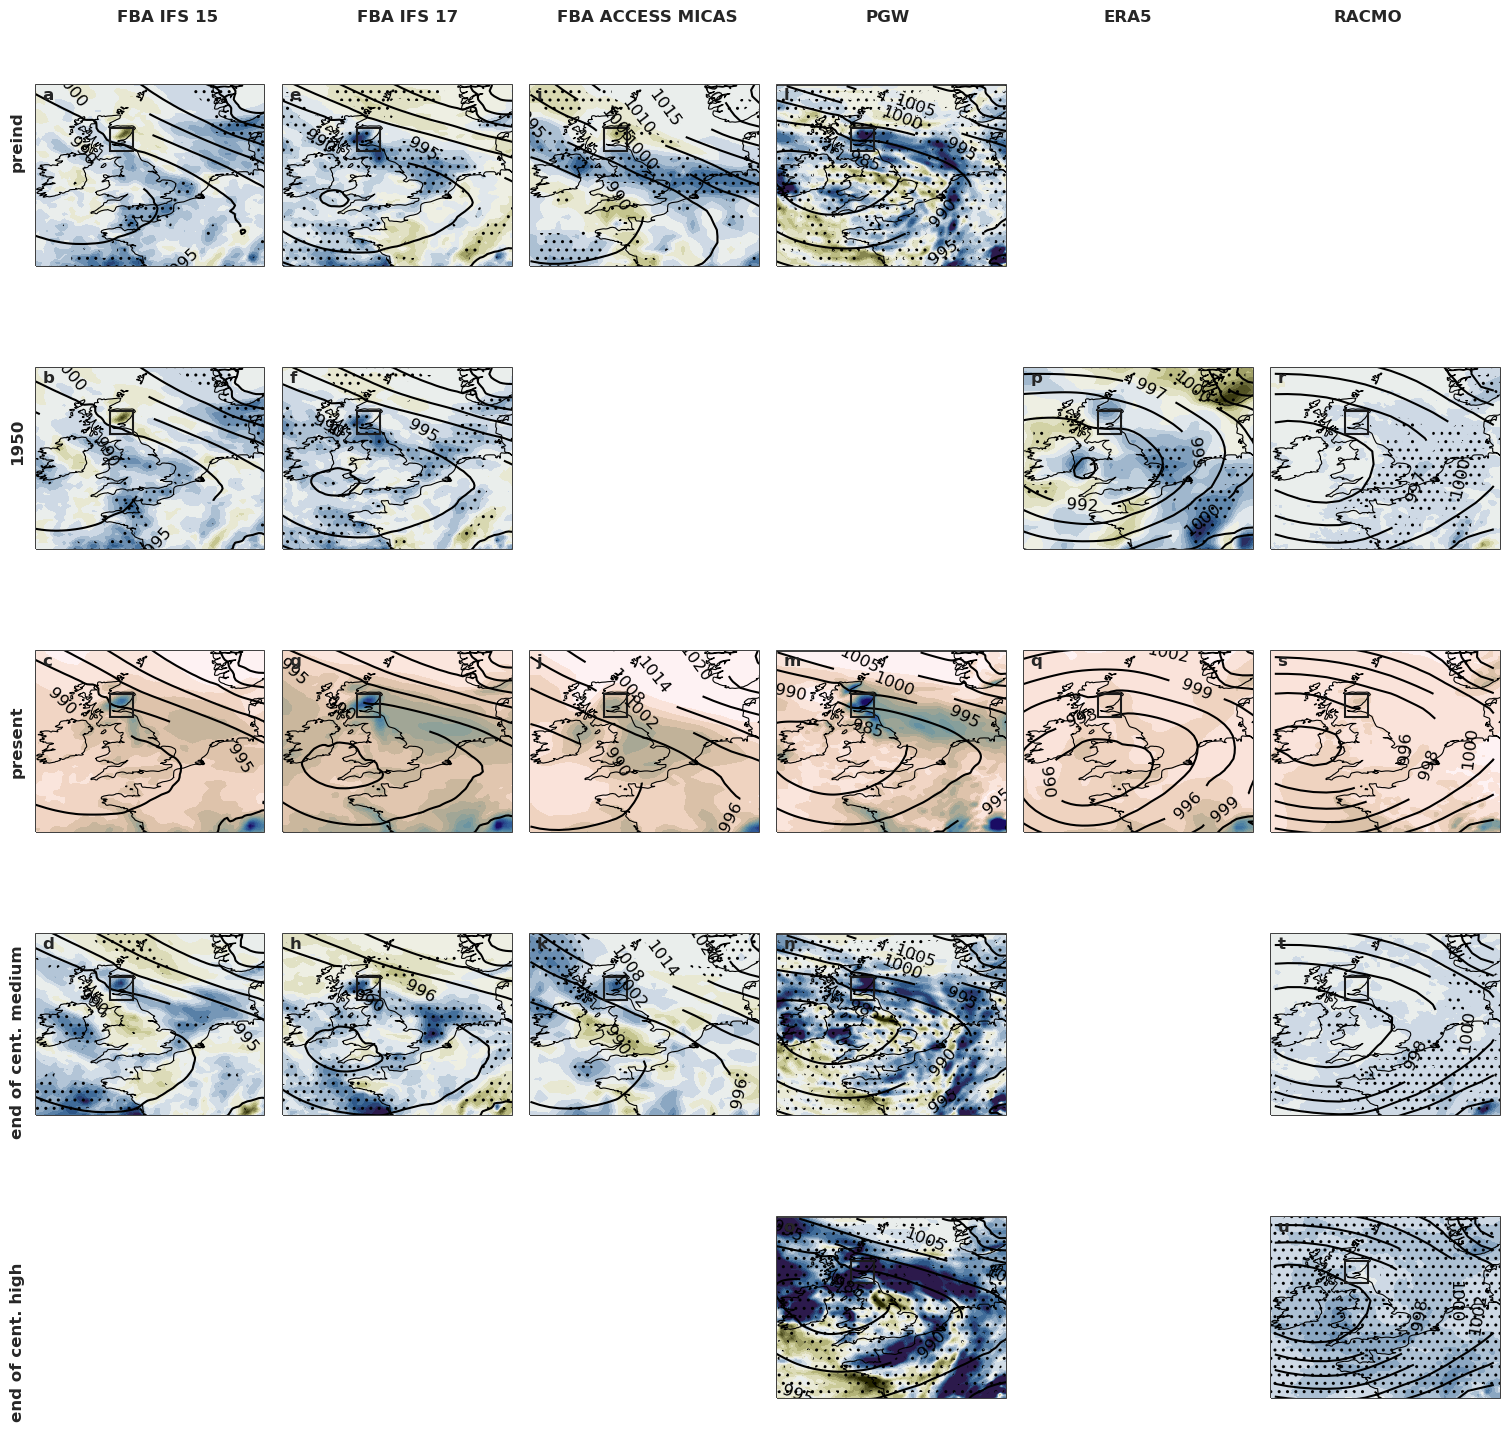

In [ ]:
# Create figure with two subplots side by side
fig, axes = plt.subplots(ncols=6, nrows=5, figsize=(15, 15), subplot_kw={'projection': ccrs.PlateCarree()})
projection = ccrs.PlateCarree()

# difference range
pr_diff = 15
pr_full = 150

# Define column headers
column_headers = ["FBA IFS 15", "FBA IFS 17", "FBA ACCESS MICAS", "PGW", "ERA5", "RACMO"]

# FBA IFS 15 --------------

# 1870
(ifs.tp.sel(climate="present") - ifs.tp.sel(climate="1870")).sel(inidate='2023-10-15').mean('number').squeeze().plot.contourf(
    cmap=cm.broc_r, vmin=-1*pr_diff, vmax=pr_diff+1, zorder=12,
    add_labels=False,
    levels=20, ax=axes[0, 0], add_colorbar=False, transform=projection
)
cs = axes[0,0].contour(ifs.longitude.values, ifs.latitude.values,ifs.msl.sel(inidate='2023-10-15', climate='1870').mean('number').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
axes[0,0].contourf(ifs_sign.longitude, ifs_sign.latitude, ifs_sign.sel(climate='1870', inidate='2023-10-15').tp, alpha=0, levels=[-0.5,0.5,1],hatches=['..', None], add_colorbar=False, zorder=17, transform=projection)

# 1950
(ifs.tp.sel(climate="present") - ifs.tp.sel(climate="1950")).sel(inidate='2023-10-15').mean('number').squeeze().plot.contourf(
    cmap=cm.broc_r, vmin=-1*pr_diff, vmax=pr_diff+1, zorder=12,
    add_labels=False,
    levels=20, ax=axes[1, 0], add_colorbar=False, transform=projection
)
cs = axes[1,0].contour(ifs.longitude.values, ifs.latitude.values,ifs.msl.sel(inidate='2023-10-15', climate='1950').mean('number').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
axes[1,0].contourf(ifs_sign.longitude, ifs_sign.latitude, ifs_sign.sel(climate='1950', inidate='2023-10-15').tp, alpha=0, levels=[-0.5,0.5,1],hatches=['..', None], add_colorbar=False, zorder=17, transform=projection)

# present
(ifs.tp.sel(climate="present")).sel(inidate='2023-10-15').mean('number').squeeze().plot.contourf(
    cmap=cm.lapaz_r, vmin=0, vmax=pr_full, zorder=12,
    add_labels=False,
    levels=20, ax=axes[2, 0], add_colorbar=False, transform=projection
)
cs = axes[2,0].contour(ifs.longitude.values, ifs.latitude.values,ifs.msl.sel(inidate='2023-10-15', climate='present').mean('number').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')

# future1
(ifs.tp.sel(climate="future1") - ifs.tp.sel(climate="present")).sel(inidate='2023-10-15').squeeze().mean('number').plot.contourf(
    cmap=cm.broc_r,  vmin=-1*pr_diff, vmax=pr_diff+1, zorder=12,
    add_labels=False,
    levels=20, ax=axes[3, 0], add_colorbar=False, transform=projection
)
cs = axes[3,0].contour(ifs.longitude.values, ifs.latitude.values,ifs.msl.sel(inidate='2023-10-15', climate='future1').mean('number').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
axes[3,0].contourf(ifs_sign.longitude, ifs_sign.latitude, ifs_sign.sel(climate='future1', inidate='2023-10-15').tp, alpha=0, levels=[-0.5,0.5,1],hatches=['..', None], add_colorbar=False, zorder=17, transform=projection)

axes[4,0].axis('off')


# FBA IFS 17 --------------

# 1870
(ifs.tp.sel(climate="present") - ifs.tp.sel(climate="1870")).sel(inidate='2023-10-17').mean('number').squeeze().plot.contourf(
    cmap=cm.broc_r,  vmin=-1*pr_diff, vmax=pr_diff+1, zorder=12,
    add_labels=False,
    levels=20, ax=axes[0, 1], add_colorbar=False, transform=projection
)
cs = axes[0,1].contour(ifs.longitude.values, ifs.latitude.values,ifs.msl.sel(inidate='2023-10-17', climate='1870').mean('number').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
axes[0,1].contourf(ifs_sign.longitude, ifs_sign.latitude, ifs_sign.sel(climate='1870', inidate='2023-10-17').tp, alpha=0, levels=[-0.5,0.5,1],hatches=['..', None], add_colorbar=False, zorder=17, transform=projection)

# 1950
(ifs.tp.sel(climate="present") - ifs.tp.sel(climate="1950")).sel(inidate='2023-10-17').mean('number').squeeze().plot.contourf(
    cmap=cm.broc_r,  vmin=-1*pr_diff, vmax=pr_diff+1, zorder=12,
    add_labels=False,
    levels=20, ax=axes[1, 1], add_colorbar=False, transform=projection
)
cs = axes[1,1].contour(ifs.longitude.values, ifs.latitude.values,ifs.msl.sel(inidate='2023-10-17', climate='1950').mean('number').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
axes[1,1].contourf(ifs_sign.longitude, ifs_sign.latitude, ifs_sign.sel(climate='1950', inidate='2023-10-17').tp, alpha=0, levels=[-0.5,0.5,1],hatches=['..', None], add_colorbar=False, zorder=17, transform=projection)

# present
(ifs.tp.sel(climate="present")).sel(inidate='2023-10-17').mean('number').squeeze().plot.contourf(
    cmap=cm.lapaz_r, vmin=0, vmax=pr_full, zorder=12,
    add_labels=False,
    levels=20, ax=axes[2, 1], add_colorbar=False, transform=projection
)
cs = axes[2,1].contour(ifs.longitude.values, ifs.latitude.values,ifs.msl.sel(inidate='2023-10-17', climate='present').mean('number').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
# future1
(ifs.tp.sel(climate="future1") - ifs.tp.sel(climate="present")).sel(inidate='2023-10-17').squeeze().mean('number').plot.contourf(
    cmap=cm.broc_r,  vmin=-1*pr_diff, vmax=pr_diff+1, zorder=12,
    add_labels=False,
    levels=20, ax=axes[3, 1], add_colorbar=False, transform=projection
)
cs = axes[3,1].contour(ifs.longitude.values, ifs.latitude.values,ifs.msl.sel(inidate='2023-10-17', climate='future1').mean('number').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
axes[3,1].contourf(ifs_sign.longitude, ifs_sign.latitude, ifs_sign.sel(climate='future1', inidate='2023-10-17').tp, alpha=0, levels=[-0.5,0.5,1],hatches=['..', None], add_colorbar=False, zorder=17, transform=projection)

axes[4,1].axis('off')

# FBA MICAS --------------

# 1870
(micas.tp.sel(climate="present") - micas.tp.sel(climate="1870")).mean('member').squeeze().plot.contourf(
    cmap=cm.broc_r,  vmin=-1*pr_diff, vmax=pr_diff+1, zorder=12,
    add_labels=False,
    levels=20, ax=axes[0, 2], add_colorbar=False, transform=projection
)
cs = axes[0,2].contour(micas.lon.values, micas.lat.values,micas.msl.sel(climate='1870').mean('member').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
axes[0,2].contourf(micas_sign.lon, micas_sign.lat, micas_sign.sel(climate='1870').tp, alpha=0, levels=[-0.5,0.5,1],hatches=['..', None], add_colorbar=False, zorder=17, transform=projection)

# present
(micas.tp.sel(climate="present")).mean('member').squeeze().plot.contourf(
    cmap=cm.lapaz_r,  vmin=0, vmax=pr_full, zorder=12,
    add_labels=False,
    levels=20, ax=axes[2, 2], add_colorbar=False, transform=projection
)
cs = axes[2,2].contour(micas.lon.values, micas.lat.values,micas.msl.sel(climate='present').mean('member').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
# future1
(micas.tp.sel(climate="future1") - micas.tp.sel(climate="present")).mean('member').squeeze().plot.contourf(
    cmap=cm.broc_r,  vmin=-1*pr_diff, vmax=pr_diff+1, zorder=12,
    add_labels=False,
    levels=20, ax=axes[3, 2], add_colorbar=False, transform=projection
)
cs = axes[3,2].contour(micas.lon.values, micas.lat.values,micas.msl.sel(climate='future1').mean('member').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
axes[3,2].contourf(micas_sign.lon, micas_sign.lat, micas_sign.sel(climate='future1').tp, alpha=0, levels=[-0.5,0.5,1],hatches=['..', None], add_colorbar=False, zorder=17, transform=projection)

axes[1,2].axis('off')
axes[4,2].axis('off')

# PGW ---------------------

# 1870
(pgw_ens.tp.sel(climate="present") - pgw_ens.tp.sel(climate="1870")).mean('member').squeeze().plot.contourf(
    cmap=cm.broc_r,  vmin=-1*pr_diff, vmax=pr_diff+1, zorder=12,
    add_labels=False,
    levels=20, ax=axes[0, 3], add_colorbar=False, transform=projection
)
cs = axes[0,3].contour(pgw_ens.lon.values, pgw_ens.lat.values,pgw_ens.msl.sel(climate='1870').mean('member').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
axes[0,3].contourf(pgw_sign.lon, pgw_sign.lat, pgw_sign.sel(climate='1870').tp, alpha=0, levels=[-0.5,0.5,1],hatches=['..', None], add_colorbar=False, zorder=17, transform=projection)
# present
(pgw_ens.tp.sel(climate="present")).mean('member').squeeze().plot.contourf(
    cmap=cm.lapaz_r,  vmin=0, vmax=pr_full, zorder=12,
    add_labels=False,
    levels=20, ax=axes[2, 3], add_colorbar=False, transform=projection
)
cs = axes[2,3].contour(pgw_ens.lon.values, pgw_ens.lat.values,pgw_ens.msl.sel(climate='present').mean('member').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
# future1
(pgw_ens.tp.sel(climate="future1") - pgw_ens.tp.sel(climate="present")).mean('member').squeeze().plot.contourf(
    cmap=cm.broc_r,  vmin=-1*pr_diff, vmax=pr_diff+1, zorder=12,
    add_labels=False,
    levels=20, ax=axes[3, 3], add_colorbar=False, transform=projection
)
cs = axes[3,3].contour(pgw_ens.lon.values, pgw_ens.lat.values,pgw_ens.msl.sel(climate='future1').mean('member').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
axes[3,3].contourf(pgw_sign.lon, pgw_sign.lat, pgw_sign.sel(climate='future1').tp, alpha=0, levels=[-0.5,0.5,1],hatches=['..', None], add_colorbar=False, zorder=17, transform=projection)
# future2
(pgw_ens.tp.sel(climate="future2") - pgw_ens.tp.sel(climate="present")).mean('member').squeeze().plot.contourf(
    cmap=cm.broc_r,  vmin=-1*pr_diff, vmax=pr_diff+1, zorder=12,
    add_labels=False,
    levels=20, ax=axes[4, 3], add_colorbar=False, transform=projection
)
cs = axes[4,3].contour(pgw_ens.lon.values, pgw_ens.lat.values,pgw_ens.msl.sel(climate='future2').mean('member').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
axes[4,3].contourf(pgw_sign.lon, pgw_sign.lat, pgw_sign.sel(climate='future2').tp, alpha=0, levels=[-0.5,0.5,1],hatches=['..', None], add_colorbar=False, zorder=17, transform=projection)

axes[1,3].axis('off')

# ERA5 --------------------

# 1950
(era5_analogues.tp.sel(climate="present") - era5_analogues.tp.sel(climate="1950")).mean('member').squeeze().plot.contourf(
    cmap=cm.broc_r,  vmin=-1*pr_diff, vmax=pr_diff+1, zorder=12,
    add_labels=False,
    levels=20, ax=axes[1, 4], add_colorbar=False, transform=projection
)
cs = axes[1,4].contour(era5_analogues.lon.values, era5_analogues.lat.values,era5_analogues.msl.sel(climate='1950').mean('member').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
axes[1,4].contourf(era5_analogues_sign.lon, era5_analogues_sign.lat, era5_analogues_sign.sel(climate='1950').tp, alpha=0, levels=[-0.5,0.5,1],hatches=['..', None], add_colorbar=False, zorder=17, transform=projection)

# present
(era5_analogues.tp.sel(climate="present")).mean('member').squeeze().plot.contourf(
    cmap=cm.lapaz_r,  vmin=0, vmax=pr_full, zorder=12,
    add_labels=False,
    levels=20, ax=axes[2, 4], add_colorbar=False, transform=projection
)
cs = axes[2,4].contour(era5_analogues.lon.values, era5_analogues.lat.values,era5_analogues.msl.sel(climate='present').mean('member').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
axes[0,4].axis('off')
axes[3,4].axis('off')
axes[4,4].axis('off')

# Make ERA5 current plot stand out
# axes[2,4].outline_patch.set_linewidth(3)  # Make frame bold
# axes[2,4].outline_patch.set_edgecolor(color_palette[2])  # Set frame color to red

# RACMO -------------------

# 1950
(racmo_tp.tp.sel(climate="present") - racmo_tp.tp.sel(climate="1950")).mean('member').squeeze().plot.contourf(
    cmap=cm.broc_r,  vmin=-1*pr_diff, vmax=pr_diff+1, zorder=12,
    add_labels=False,
    levels=20, ax=axes[1, 5], add_colorbar=False, transform=projection
)
cs = axes[1,5].contour(racmo_msl.lon.values, racmo_msl.lat.values,racmo_msl.msl.sel(climate='1950').mean('member').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
axes[1,5].contourf(racmo_sign.lon, racmo_sign.lat, racmo_sign.sel(climate='1950').tp, alpha=0, levels=[-0.5,0.5,1],hatches=['..', None], add_colorbar=False, zorder=17, transform=projection)

# present
(racmo_tp.tp.sel(climate="present")).mean('member').squeeze().plot.contourf(
    cmap=cm.lapaz_r,  vmin=0, vmax=pr_full, zorder=12,
    add_labels=False,
    levels=20, ax=axes[2, 5], add_colorbar=False, transform=projection
)
cs = axes[2,5].contour(racmo_msl.lon.values, racmo_msl.lat.values,racmo_msl.msl.sel(climate='present').mean('member').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')

# future1
(racmo_tp.tp.sel(climate="future1") - racmo_tp.tp.sel(climate="present")).mean('member').squeeze().plot.contourf(
    cmap=cm.broc_r,  vmin=-1*pr_diff, vmax=pr_diff+1, zorder=12,
    add_labels=False,
    levels=20, ax=axes[3, 5], add_colorbar=False, transform=projection
)
cs = axes[3,5].contour(racmo_msl.lon.values, racmo_msl.lat.values, racmo_msl.msl.sel(climate='future1').mean('member').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
axes[3,5].contourf(racmo_sign.lon, racmo_sign.lat, racmo_sign.sel(climate='future1').tp, alpha=0, levels=[-0.5,0.5,1],hatches=['..', None], add_colorbar=False, zorder=17, transform=projection)


# future2
(racmo_tp.tp.sel(climate="future2") - racmo_tp.tp.sel(climate="present")).mean('member').squeeze().plot.contourf(
    cmap=cm.broc_r,  vmin=-1*pr_diff, vmax=pr_diff+1, zorder=12,
    add_labels=False,
    levels=20, ax=axes[4, 5], add_colorbar=False, transform=projection
)
cs = axes[4,5].contour(racmo_msl.lon.values, racmo_msl.lat.values, racmo_msl.msl.sel(climate='future2').mean('member').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
axes[4,5].contourf(racmo_sign.lon, racmo_sign.lat, racmo_sign.sel(climate='future2').tp, alpha=0, levels=[-0.5,0.5,1],hatches=['..', None], add_colorbar=False, zorder=17, transform=projection)


axes[0,5].axis('off')



# Figure settings ----------

labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u']
axes_with_data = [axes[0,0], axes[1,0], axes[2,0], axes[3,0], # FBA IFS 15
                  axes[0,1], axes[1,1], axes[2,1], axes[3,1], # FBA IFS 17
                  axes[0,2], axes[2,2], axes[3,2], # FBA ACCESS
                  axes[0,3], axes[2,3], axes[3,3], axes[4,3], # PGW
                  axes[1,4], axes[2,4], # ERA5
                  axes[1,5], axes[2,5], axes[3,5], axes[4,5], # RACMO

]

# Apply Cartopy settings to both axes
for ax, label in zip(axes_with_data, labels):
    ax.set_extent(uk, crs=ccrs.PlateCarree())  # Set map extent
    if ax in []:
        ax.add_feature(cfeature.COASTLINE, edgecolor='grey', linewidth=0.8, zorder = 14)  # Add land borders
    else:
        ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.8, zorder = 14)  # Add land borders
    ax.coastlines()  # Add coastlines
    ax.text(0.03, 0.92, label, transform=ax.transAxes, fontsize=12, fontweight="bold", zorder=20)

    rectangle = patches.Rectangle((-4, 55.5), 2, 2, linewidth=1.5, 
                                edgecolor='k', 
                                facecolor='none',
                                transform=projection)
    ax.add_patch(rectangle)
    rectangle.set_zorder(17)

# Add column headers
col_locs = np.linspace(0.1, 0.9, len(column_headers))
for col_idx, col_name in enumerate(column_headers):
    fig.text(col_locs[col_idx], 0.98, col_name, fontsize=12, ha='center',  fontweight='bold')

# Define row headers
row_headers = ["preind", "1950", "present", "end of cent. medium", "end of cent. high"]

# Add row headers rotated by 90 degrees
for i, label in enumerate(row_headers):
    fig.text(0.00, 1 - (i + 0.5) / 5, label, va='center', ha='center', 
             fontsize=12, rotation=90, fontweight='bold')

plt.tight_layout()

# Save plot
plt.savefig('figures/PAPER3_map_plots.png', dpi=600, bbox_inches='tight')
plt.savefig('figures/PAPER3_map_plots.pdf')

/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1714: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1714: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1714: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1714: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = matplotlib.axes.Axes.contourf(self, *args

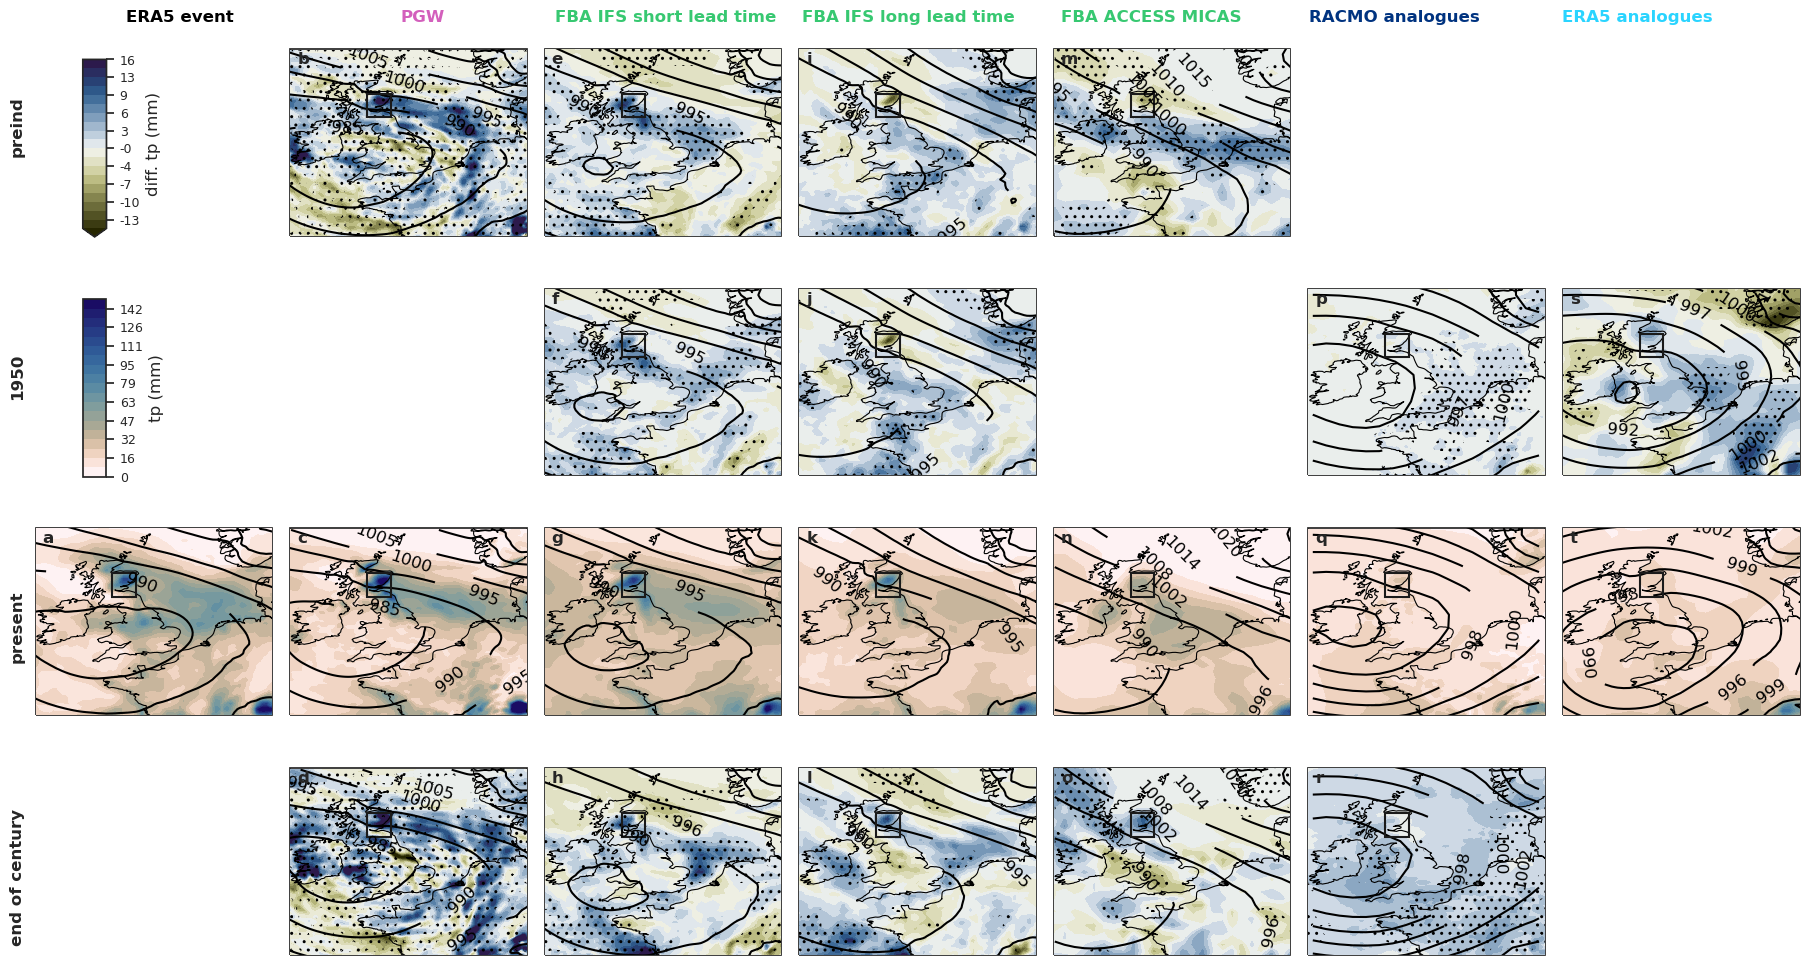

In [19]:
# Create figure with two subplots side by side
colors_methods = ['black', '#d35fbc', '#37c871', '#37c871', '#37c871', '#003380', '#2ad4ff', '#d45500'] # pgw, ifs short, ifs long, micas, racmo, era5, probabilistic
fig, axes = plt.subplots(ncols=7, nrows=4, figsize=(18, 10), subplot_kw={'projection': ccrs.PlateCarree()})
projection = ccrs.PlateCarree()

# difference range
pr_diff = 15
pr_full = 150

# Define column headers
column_headers = ["ERA5 event", "PGW", "FBA IFS short lead time", "FBA IFS long lead time", "FBA ACCESS MICAS", "RACMO analogues", "ERA5 analogues"]

# ERA5 event --------------

# present
(era5_babet_tp).squeeze().plot.contourf(
    cmap=cm.lapaz_r,  vmin=0, vmax=pr_full, zorder=12,
    add_labels=False,
    levels=20, ax=axes[2,0], add_colorbar=False,  transform=projection
)

cs = axes[2,0].contour(era5.longitude.values, era5.latitude.values,era5_babet_msl.squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
axes[0,0].axis('off')
axes[1,0].axis('off')
axes[3,0].axis('off')

# PGW ---------------------

# 1870
(pgw_ens.tp.sel(climate="present") - pgw_ens.tp.sel(climate="1870")).mean('member').squeeze().plot.contourf(
    cmap=cm.broc_r,  vmin=-1*pr_diff, vmax=pr_diff+1, zorder=12,
    add_labels=False,
    levels=20, ax=axes[0, 1], add_colorbar=False, transform=projection
)
cs = axes[0,1].contour(pgw_ens.lon.values, pgw_ens.lat.values,pgw_ens.msl.sel(climate='1870').mean('member').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
axes[0,1].contourf(pgw_sign.lon, pgw_sign.lat, pgw_sign.sel(climate='1870').tp, alpha=0, levels=[-0.5,0.5,1],hatches=['..', None], add_colorbar=False, zorder=17, transform=projection)

# present
(pgw_ens.tp.sel(climate="present")).mean('member').squeeze().plot.contourf(
    cmap=cm.lapaz_r,  vmin=0, vmax=pr_full, zorder=12,
    add_labels=False,
    levels=20, ax=axes[2, 1], add_colorbar=False, transform=projection
)
cs = axes[2,1].contour(pgw_ens.lon.values, pgw_ens.lat.values,pgw_ens.msl.sel(climate='present').mean('member').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
# future1
(pgw_ens.tp.sel(climate="future1") - pgw_ens.tp.sel(climate="present")).mean('member').squeeze().plot.contourf(
    cmap=cm.broc_r,  vmin=-1*pr_diff, vmax=pr_diff+1, zorder=12,
    add_labels=False,
    levels=20, ax=axes[3, 1], add_colorbar=False, transform=projection
)
cs = axes[3,1].contour(pgw_ens.lon.values, pgw_ens.lat.values,pgw_ens.msl.sel(climate='future1').mean('member').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
axes[3,1].contourf(pgw_sign.lon, pgw_sign.lat, pgw_sign.sel(climate='future1').tp, alpha=0, levels=[-0.5,0.5,1],hatches=['..', None], add_colorbar=False, zorder=17, transform=projection)

axes[1,1].axis('off')


# FBA IFS 17 --------------

# 1870
(ifs.tp.sel(climate="present") - ifs.tp.sel(climate="1870")).sel(inidate='2023-10-17').mean('number').squeeze().plot.contourf(
    cmap=cm.broc_r,  vmin=-1*pr_diff, vmax=pr_diff+1, zorder=12,
    add_labels=False,
    levels=20, ax=axes[0, 2], add_colorbar=False, transform=projection
)
cs = axes[0,2].contour(ifs.longitude.values, ifs.latitude.values,ifs.msl.sel(inidate='2023-10-17', climate='1870').mean('number').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
axes[0,2].contourf(ifs_sign.longitude, ifs_sign.latitude, ifs_sign.sel(climate='1870', inidate='2023-10-17').tp, alpha=0, levels=[-0.5,0.5,1],hatches=['..', None], add_colorbar=False, zorder=17, transform=projection)

# 1950
(ifs.tp.sel(climate="present") - ifs.tp.sel(climate="1950")).sel(inidate='2023-10-17').mean('number').squeeze().plot.contourf(
    cmap=cm.broc_r,  vmin=-1*pr_diff, vmax=pr_diff+1, zorder=12,
    add_labels=False,
    levels=20, ax=axes[1, 2], add_colorbar=False, transform=projection
)

cs = axes[1,2].contour(ifs.longitude.values, ifs.latitude.values,ifs.msl.sel(inidate='2023-10-17', climate='1950').mean('number').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
axes[1,2].contourf(ifs_sign.longitude, ifs_sign.latitude, ifs_sign.sel(climate='1950', inidate='2023-10-17').tp, alpha=0, levels=[-0.5,0.5,1],hatches=['..', None], add_colorbar=False, zorder=17, transform=projection)

# present
(ifs.tp.sel(climate="present")).sel(inidate='2023-10-17').mean('number').squeeze().plot.contourf(
    cmap=cm.lapaz_r, vmin=0, vmax=pr_full, zorder=12,
    add_labels=False,
    levels=20, ax=axes[2, 2], add_colorbar=False, transform=projection
)
cs = axes[2,2].contour(ifs.longitude.values, ifs.latitude.values,ifs.msl.sel(inidate='2023-10-17', climate='present').mean('number').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
# future1
(ifs.tp.sel(climate="future1") - ifs.tp.sel(climate="present")).sel(inidate='2023-10-17').squeeze().mean('number').plot.contourf(
    cmap=cm.broc_r,  vmin=-1*pr_diff, vmax=pr_diff+1, zorder=12,
    add_labels=False,
    levels=20, ax=axes[3, 2], add_colorbar=False, transform=projection
)
cs = axes[3,2].contour(ifs.longitude.values, ifs.latitude.values,ifs.msl.sel(inidate='2023-10-17', climate='future1').mean('number').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
axes[3,2].contourf(ifs_sign.longitude, ifs_sign.latitude, ifs_sign.sel(climate='future1', inidate='2023-10-17').tp, alpha=0, levels=[-0.5,0.5,1],hatches=['..', None], add_colorbar=False, zorder=17, transform=projection)


# FBA IFS 15 --------------

# 1870
(ifs.tp.sel(climate="present") - ifs.tp.sel(climate="1870")).sel(inidate='2023-10-15').mean('number').squeeze().plot.contourf(
    cmap=cm.broc_r, vmin=-1*pr_diff, vmax=pr_diff+1, zorder=12,
    add_labels=False,
    levels=20, ax=axes[0, 3], add_colorbar=False, transform=projection
)
cs = axes[0,3].contour(ifs.longitude.values, ifs.latitude.values,ifs.msl.sel(inidate='2023-10-15', climate='1870').mean('number').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
axes[0,3].contourf(ifs_sign.longitude, ifs_sign.latitude, ifs_sign.sel(climate='1870', inidate='2023-10-15').tp, alpha=0, levels=[-0.5,0.5,1],hatches=['..', None], add_colorbar=False, zorder=17, transform=projection)

# 1950
(ifs.tp.sel(climate="present") - ifs.tp.sel(climate="1950")).sel(inidate='2023-10-15').mean('number').squeeze().plot.contourf(
    cmap=cm.broc_r, vmin=-1*pr_diff, vmax=pr_diff+1, zorder=12,
    add_labels=False,
    levels=20, ax=axes[1, 3], add_colorbar=False, transform=projection
)

cs = axes[1,3].contour(ifs.longitude.values, ifs.latitude.values,ifs.msl.sel(inidate='2023-10-15', climate='1950').mean('number').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
axes[1,3].contourf(ifs_sign.longitude, ifs_sign.latitude, ifs_sign.sel(climate='1950', inidate='2023-10-15').tp, alpha=0, levels=[-0.5,0.5,1],hatches=['..', None], add_colorbar=False, zorder=17, transform=projection)

# present
(ifs.tp.sel(climate="present")).sel(inidate='2023-10-15').mean('number').squeeze().plot.contourf(
    cmap=cm.lapaz_r, vmin=0, vmax=pr_full, zorder=12,
    add_labels=False,
    levels=20, ax=axes[2, 3], add_colorbar=False, transform=projection
)

cs = axes[2,3].contour(ifs.longitude.values, ifs.latitude.values,ifs.msl.sel(inidate='2023-10-15', climate='present').mean('number').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')

# future1
(ifs.tp.sel(climate="future1") - ifs.tp.sel(climate="present")).sel(inidate='2023-10-15').squeeze().mean('number').plot.contourf(
    cmap=cm.broc_r,  vmin=-1*pr_diff, vmax=pr_diff+1, zorder=12,
    add_labels=False,
    levels=20, ax=axes[3, 3], add_colorbar=False, transform=projection
)
cs = axes[3,3].contour(ifs.longitude.values, ifs.latitude.values,ifs.msl.sel(inidate='2023-10-15', climate='future1').mean('number').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
axes[3,3].contourf(ifs_sign.longitude, ifs_sign.latitude, ifs_sign.sel(climate='future1', inidate='2023-10-15').tp, alpha=0, levels=[-0.5,0.5,1],hatches=['..', None], add_colorbar=False, zorder=17, transform=projection)

# FBA MICAS --------------

# 1870
(micas.tp.sel(climate="present") - micas.tp.sel(climate="1870")).mean('member').squeeze().plot.contourf(
    cmap=cm.broc_r,  vmin=-1*pr_diff, vmax=pr_diff+1, zorder=12,
    add_labels=False,
    levels=20, ax=axes[0, 4], add_colorbar=False, transform=projection
)
cs = axes[0,4].contour(micas.lon.values, micas.lat.values,micas.msl.sel(climate='1870').mean('member').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
axes[0,4].contourf(micas_sign.lon, micas_sign.lat, micas_sign.sel(climate='1870').tp, alpha=0, levels=[-0.5,0.5,1],hatches=['..', None], add_colorbar=False, zorder=17, transform=projection)

# present
(micas.tp.sel(climate="present")).mean('member').squeeze().plot.contourf(
    cmap=cm.lapaz_r,  vmin=0, vmax=pr_full, zorder=12,
    add_labels=False,
    levels=20, ax=axes[2, 4], add_colorbar=False, transform=projection
)
cs = axes[2,4].contour(micas.lon.values, micas.lat.values,micas.msl.sel(climate='present').mean('member').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
# future1
(micas.tp.sel(climate="future1") - micas.tp.sel(climate="present")).mean('member').squeeze().plot.contourf(
    cmap=cm.broc_r,  vmin=-1*pr_diff, vmax=pr_diff+1, zorder=12,
    add_labels=False,
    levels=20, ax=axes[3, 4], add_colorbar=False, transform=projection
)
cs = axes[3,4].contour(micas.lon.values, micas.lat.values,micas.msl.sel(climate='future1').mean('member').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
axes[3,4].contourf(micas_sign.lon, micas_sign.lat, micas_sign.sel(climate='future1').tp, alpha=0, levels=[-0.5,0.5,1],hatches=['..', None], add_colorbar=False, zorder=17, transform=projection)

axes[1,4].axis('off')

# RACMO -------------------

# 1950
(racmo_tp.tp.sel(climate="present") - racmo_tp.tp.sel(climate="1950")).mean('member').squeeze().plot.contourf(
    cmap=cm.broc_r,  vmin=-1*pr_diff, vmax=pr_diff+1, zorder=12,
    add_labels=False,
    levels=20, ax=axes[1, 5], add_colorbar=False, transform=projection
)
cs = axes[1,5].contour(racmo_msl.lon.values, racmo_msl.lat.values,racmo_msl.msl.sel(climate='1950').mean('member').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
axes[1,5].contourf(racmo_sign.lon, racmo_sign.lat, racmo_sign.sel(climate='1950').tp, alpha=0, levels=[-0.5,0.5,1],hatches=['..', None], add_colorbar=False, zorder=17, transform=projection)

# present
(racmo_tp.tp.sel(climate="present")).mean('member').squeeze().plot.contourf(
    cmap=cm.lapaz_r,  vmin=0, vmax=pr_full, zorder=12,
    add_labels=False,
    levels=20, ax=axes[2, 5], add_colorbar=False, transform=projection
)
cs = axes[2,5].contour(racmo_msl.lon.values, racmo_msl.lat.values,racmo_msl.msl.sel(climate='present').mean('member').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')

# future1
(racmo_tp.tp.sel(climate="future1") - racmo_tp.tp.sel(climate="present")).mean('member').squeeze().plot.contourf(
    cmap=cm.broc_r,  vmin=-1*pr_diff, vmax=pr_diff+1, zorder=12,
    add_labels=False,
    levels=20, ax=axes[3, 5], add_colorbar=False, transform=projection
)
cs = axes[3,5].contour(racmo_msl.lon.values, racmo_msl.lat.values, racmo_msl.msl.sel(climate='future1').mean('member').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
axes[3,5].contourf(racmo_sign.lon, racmo_sign.lat, racmo_sign.sel(climate='future1').tp, alpha=0, levels=[-0.5,0.5,1],hatches=['..', None], add_colorbar=False, zorder=17, transform=projection)

axes[0,5].axis('off')

# ERA5 --------------------

# 1950
cf_diff = (era5_analogues.tp.sel(climate="present") - era5_analogues.tp.sel(climate="1950")).mean('member').squeeze().plot.contourf(
    cmap=cm.broc_r,  vmin=-1*pr_diff, vmax=pr_diff+1, zorder=12,
    add_labels=False,
    levels=20, ax=axes[1, 6], add_colorbar=False, transform=projection
)
cs = axes[1,6].contour(era5_analogues.lon.values, era5_analogues.lat.values,era5_analogues.msl.sel(climate='1950').mean('member').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
axes[1,6].contourf(era5_analogues_sign.lon, era5_analogues_sign.lat, era5_analogues_sign.sel(climate='1950').tp, alpha=0, levels=[-0.5,0.5,1],hatches=['..', None], add_colorbar=False, zorder=17, transform=projection)

# present
cf = (era5_analogues.tp.sel(climate="present")).mean('member').squeeze().plot.contourf(
    cmap=cm.lapaz_r,  vmin=0, vmax=pr_full, zorder=12,
    add_labels=False,
    levels=20, ax=axes[2, 6], add_colorbar=False, transform=projection
)
cs = axes[2,6].contour(era5_analogues.lon.values, era5_analogues.lat.values,era5_analogues.msl.sel(climate='present').mean('member').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
axes[0,6].axis('off')
axes[3,6].axis('off')

# Figure settings ----------

labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v']
axes_with_data = [axes[2,0], # ERA5 event
                  axes[0,1], axes[2,1], axes[3,1], # PGW
                  axes[0,2], axes[1,2], axes[2,2], axes[3,2], # FBA IFS 17
                  axes[0,3], axes[1,3], axes[2,3], axes[3,3], # FBA IFS 15
                  axes[0,4], axes[2,4], axes[3,4], # FBA ACCESS
                  axes[1,5], axes[2,5], axes[3,5], # RACMO
                  axes[1,6], axes[2,6], # ERA5

]

# Apply Cartopy settings to both axes
for ax, label in zip(axes_with_data, labels):
    ax.set_extent(uk, crs=ccrs.PlateCarree())  # Set map extent
    if ax in []:
        ax.add_feature(cfeature.COASTLINE, edgecolor='grey', linewidth=0.8, zorder = 14)  # Add land borders
    else:
        ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.8, zorder = 14)  # Add land borders
    ax.coastlines()  # Add coastlines
    ax.text(0.03, 0.92, label, transform=ax.transAxes, fontsize=12, fontweight="bold", zorder=20)

    rectangle = patches.Rectangle((-4, 55.5), 2, 2, linewidth=1.5, 
                                edgecolor='k', 
                                facecolor='none',
                                transform=projection)
    ax.add_patch(rectangle)
    rectangle.set_zorder(17)

# Add column headers
col_locs = np.linspace(0.09, 0.9, len(column_headers))
for col_idx, col_name in enumerate(column_headers):
    fig.text(col_locs[col_idx], 0.98, col_name, fontsize=12, ha='center',  fontweight='bold', color=colors_methods[col_idx])

# Define row headers
row_headers = ["preind", "1950", "present", "end of century"]

# Add row headers rotated by 90 degrees
for i, label in enumerate(row_headers):
    fig.text(0.00, 1 - (i + 0.5) / 4, label, va='center', ha='center', 
             fontsize=12, rotation=90, fontweight='bold')

# Add colourbars
cax = axes[1,0].inset_axes([0.2, -0.3, 0.1, 1.5])  # creates inset, [x0,y0, width, height]
cbar = fig.colorbar(cf, cax=cax, label='tp (mm)', extend = 'max', format='%.0f') # shrink=0.8
cbar.set_label(label='tp (mm)', size=12)
cbar.ax.tick_params(labelsize=9)

cax = axes[0,0].inset_axes([0.2, -0.3, 0.1, 1.5])  # creates inset, [x0,y0, width, height]
cbar = fig.colorbar(cf_diff, cax=cax, label='diff. tp (mm)', extend = 'max', format='%.0f')
cbar.set_label(label='diff. tp (mm)', size=12)
cbar.ax.tick_params(labelsize=9)

plt.tight_layout()

# Save plot
plt.savefig('figures/PAPER3_map_plots.png', dpi=600, bbox_inches='tight')
plt.savefig('figures/PAPER3_map_plots.pdf')

# Testing code for significance testing

In [23]:
def bootstrap_sample(data, n_iterations=10):
    """Bootstrap resampling with replacement."""
    means = np.array([
        np.mean(np.random.choice(data, size=len(data), replace=True))
        for _ in range(n_iterations)
    ])
    return np.percentile(means, [2.5, 97.5])  # 95% confidence interval

In [24]:
# Apply bootstrap to each grid cell along a specific dimension (e.g., 'time')
bootstrapped = xr.apply_ufunc(
    bootstrap_sample, 
    era5_analogues.tp-era5_analogues.tp.sel(climate='present'), 
    input_core_dims=[['member']],  # Modify based on your data dimensions
    vectorize=True,  # Ensures element-wise computation
    dask="parallelized",  # Enables parallel execution if data is chunked
    output_core_dims=[["percentile"]],  # Output contains percentiles
)

bootstrapped = bootstrapped.assign_coords(percentile=[2.5, 97.5])

In [25]:
# bootstrapped.sel(climate='1950', percentile=97.5).plot.contourf(levels=20)
zero_in_interval = ((bootstrapped.sel(climate='1950', percentile=2.5) <= 0) & (0 <= bootstrapped.sel(climate='1950', percentile=97.5))) | ((bootstrapped.sel(climate='1950', percentile=97.5) <= 0) & (0 <= bootstrapped.sel(climate='1950', percentile=2.5)))

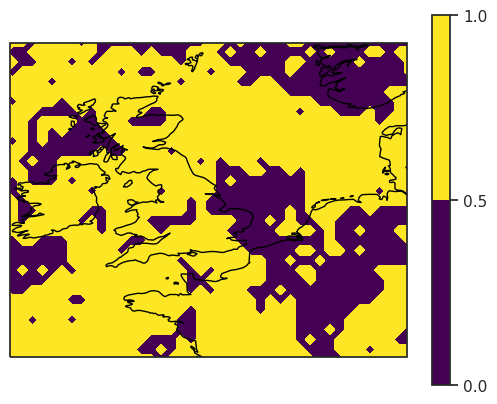

In [26]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
zero_in_interval.plot.contourf(levels=3, ax=ax, transform=ccrs.PlateCarree(), add_labels=False)
ax.coastlines()
ax.set_extent(uk, crs=ccrs.PlateCarree())

In [27]:
bootstrapped = xr.apply_ufunc(
    bootstrap_sample,
    ifs.tp-ifs.tp.sel(climate='present'),
    input_core_dims=[['number']],
    vectorize=True,
    dask="parallelized",
    output_core_dims=[["percentile"]],
    dask_gufunc_kwargs={"output_sizes": {"percentile": 2}}
    )
ifs_sign = bootstrapped.assign_coords(percentile=[2.5, 97.5])

ValueError: dimension number on 0th function argument to apply_ufunc with dask='parallelized' consists of multiple chunks, but is also a core dimension. To fix, either rechunk into a single dask array chunk along this dimension, i.e., ``.chunk(dict(number=-1))``, or pass ``allow_rechunk=True`` in ``dask_gufunc_kwargs`` but beware that this may significantly increase memory usage.

# Significance test for Aberdeenshire box -- KS tests

In [18]:
import scipy as sc

In [19]:
aberdeen = [-4, -2, 55.5, 57.2]

In [20]:
# ERA5 analogues
print('ERA5 ANALOGUES')
aberdeen_1950 = era5_analogues.tp.sel(climate='1950').sel(lat=slice(aberdeen[3], aberdeen[2]), lon=slice(aberdeen[0], aberdeen[1])).mean(['lat', 'lon']).values
aberdeen_present = era5_analogues.tp.sel(climate='present').sel(lat=slice(aberdeen[3], aberdeen[2]), lon=slice(aberdeen[0], aberdeen[1])).mean(['lat', 'lon']).values

print(f'1950 v present:  {sc.stats.kstest(aberdeen_1950, aberdeen_present).pvalue:.4f}')

ERA5 ANALOGUES
1950 v present:  0.9357


In [50]:
# RACMO
print('RACMO analogues')
aberdeen_1870 = racmo_tp.tp.sel(climate='1950',
                             lat=slice(aberdeen[2], aberdeen[3]),
                             lon=slice(aberdeen[0], aberdeen[1])).mean(['lat', 'lon']).values
aberdeen_present = racmo_tp.tp.sel(climate='present',
                                lat=slice(aberdeen[2], aberdeen[3]),
                                lon=slice(aberdeen[0], aberdeen[1])).mean(['lat', 'lon']).values
aberdeen_future1 = racmo_tp.tp.sel(climate='future1',
                                lat=slice(aberdeen[2], aberdeen[3]),
                                lon=slice(aberdeen[0], aberdeen[1])).mean(['lat', 'lon']).values
aberdeen_future2 = racmo_tp.tp.sel(climate='future2',
                                lat=slice(aberdeen[2], aberdeen[3]),
                                lon=slice(aberdeen[0], aberdeen[1])).mean(['lat', 'lon']).values

print(f'1870 v present: {sc.stats.kstest(aberdeen_1870, aberdeen_present).pvalue:.3f}')
print(f'1870 v future1: {sc.stats.kstest(aberdeen_1870, aberdeen_future1).pvalue:.3f}')
print(f'present v future1: {sc.stats.kstest(aberdeen_present, aberdeen_future1).pvalue:.3f}')
print(f'present v future2: {sc.stats.kstest(aberdeen_present, aberdeen_future2).pvalue:.3f}')

RACMO analogues
1870 v present: 0.249
1870 v future1: 0.004
present v future1: 0.117
present v future2: 0.117


In [25]:
# FBA IFS 15
print('FBA IFS 15, long lead time')
aberdeen_1870 = ifs.tp.sel(climate='1870').sel(latitude=slice(aberdeen[3], aberdeen[2]), 
                                               longitude=slice(aberdeen[0], aberdeen[1]), 
                                               inidate='2023-10-15').mean(['latitude', 'longitude']).values
aberdeen_1950 = ifs.tp.sel(climate='1950').sel(latitude=slice(aberdeen[3], aberdeen[2]),
                                               longitude=slice(aberdeen[0], aberdeen[1]), 
                                               inidate='2023-10-15').mean(['latitude', 'longitude']).values
aberdeen_present = ifs.tp.sel(climate='present').sel(latitude=slice(aberdeen[3], aberdeen[2]),
                                               longitude=slice(aberdeen[0], aberdeen[1]), 
                                               inidate='2023-10-15').mean(['latitude', 'longitude']).values
aberdeen_future1 = ifs.tp.sel(climate='future1').sel(latitude=slice(aberdeen[3], aberdeen[2]),
                                               longitude=slice(aberdeen[0], aberdeen[1]), 
                                               inidate='2023-10-15').mean(['latitude', 'longitude']).values

print(f'1870 v 1950: {sc.stats.kstest(aberdeen_1870, aberdeen_1950).pvalue:.3f}')
print(f'1870 v present:  {sc.stats.kstest(aberdeen_1870, aberdeen_present).pvalue:.3f}')
print(f'1950 v present: {sc.stats.kstest(aberdeen_1950, aberdeen_present).pvalue:.3f}')
print(f'present v future1: {sc.stats.kstest(aberdeen_present, aberdeen_future1).pvalue:.3f}')
print(f'1870 v future1: {sc.stats.kstest(aberdeen_1870, aberdeen_future1).pvalue:.3f}')

FBA IFS 15, long lead time
1870 v 1950: 0.877
1870 v present:  0.728
1950 v present: 0.970
present v future1: 0.877
1870 v future1: 0.408


In [47]:
# FBA IFS 17
print('FBA IFS 17, short lead time')
aberdeen_1870 = ifs.tp.sel(climate='1870').sel(latitude=slice(aberdeen[3], aberdeen[2]), 
                                               longitude=slice(aberdeen[0], aberdeen[1]), 
                                               inidate='2023-10-17').mean(['latitude', 'longitude']).values
aberdeen_1950 = ifs.tp.sel(climate='1950').sel(latitude=slice(aberdeen[3], aberdeen[2]),
                                               longitude=slice(aberdeen[0], aberdeen[1]), 
                                               inidate='2023-10-17').mean(['latitude', 'longitude']).values
aberdeen_present = ifs.tp.sel(climate='present').sel(latitude=slice(aberdeen[3], aberdeen[2]),
                                               longitude=slice(aberdeen[0], aberdeen[1]), 
                                               inidate='2023-10-17').mean(['latitude', 'longitude']).values
aberdeen_future1 = ifs.tp.sel(climate='future1').sel(latitude=slice(aberdeen[3], aberdeen[2]),
                                               longitude=slice(aberdeen[0], aberdeen[1]), 
                                               inidate='2023-10-17').mean(['latitude', 'longitude']).values

print(f'1870 v 1950: {sc.stats.kstest(aberdeen_1870, aberdeen_1950).pvalue:.3f}')
print(f'1870 v present:  {sc.stats.kstest(aberdeen_1870, aberdeen_present).pvalue:.3f}')
print(f'1950 v present: {sc.stats.kstest(aberdeen_1950, aberdeen_present).pvalue:.3f}')
print(f'present v future1: {sc.stats.kstest(aberdeen_present, aberdeen_future1).pvalue:.3f}')
print(f'1870 v future1: {sc.stats.kstest(aberdeen_1870, aberdeen_future1).pvalue:.3f}')

FBA IFS 17, short lead time
1870 v 1950: 0.728
1870 v present:  0.042
1950 v present: 0.283
present v future1: 0.024
1870 v future1: 0.001


In [27]:
# FBA MICAS
print('FBA ACCESS-MICAS')
aberdeen_1870 = micas.tp.sel(climate='1870',
                             lat=slice(aberdeen[2], aberdeen[3]),
                             lon=slice(aberdeen[0], aberdeen[1])).mean(['lat', 'lon']).values
aberdeen_present = micas.tp.sel(climate='present',
                                lat=slice(aberdeen[2], aberdeen[3]),
                                lon=slice(aberdeen[0], aberdeen[1])).mean(['lat', 'lon']).values
aberdeen_future1 = micas.tp.sel(climate='future1',
                                lat=slice(aberdeen[2], aberdeen[3]),
                                lon=slice(aberdeen[0], aberdeen[1])).mean(['lat', 'lon']).values

print(f'1870 v present: {sc.stats.kstest(aberdeen_1870, aberdeen_present).pvalue:.4f}')
print(f'1870 v future1: {sc.stats.kstest(aberdeen_1870, aberdeen_future1).pvalue:.4f}')
print(f'present v future1: {sc.stats.kstest(aberdeen_present, aberdeen_future1).pvalue:.4f}')

FBA ACCESS-MICAS
1870 v present: 0.6543
1870 v future1: 0.6543
present v future1: 0.6543


In [46]:
# PGW
print('PGW')
aberdeen_1870 = pgw_ens.tp.sel(climate='1870',
                             lat=slice(aberdeen[2], aberdeen[3]),
                             lon=slice(aberdeen[0], aberdeen[1])).mean(['lat', 'lon']).values
aberdeen_present = pgw_ens.tp.sel(climate='present',
                                lat=slice(aberdeen[2], aberdeen[3]),
                                lon=slice(aberdeen[0], aberdeen[1])).mean(['lat', 'lon']).values
aberdeen_future1 = pgw_ens.tp.sel(climate='future1',
                                lat=slice(aberdeen[2], aberdeen[3]),
                                lon=slice(aberdeen[0], aberdeen[1])).mean(['lat', 'lon']).values

print(f'1870 v present: {sc.stats.kstest(aberdeen_1870, aberdeen_present).pvalue:.3f}')
print(f'1870 v future1: {sc.stats.kstest(aberdeen_1870, aberdeen_future1).pvalue:.3f}')
print(f'present v future1: {sc.stats.kstest(aberdeen_present, aberdeen_future1).pvalue:.3f}')

PGW
1870 v present: 0.771
1870 v future1: 0.229
present v future1: 0.771
